### This script is same as dist-s1-research/marshak/L_ad_hoc_data_generation/1__DIST-HLS.ipynb

In [7]:
import geopandas as gpd

from pystac_client import Client  
from pystac_client import ItemSearch
from pystac.item import Item
from shapely.geometry import box, shape
import yaml
from rasterio.crs import CRS
import datetime
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import rasterio
from rasterio.merge import merge
import numpy as np
import asf_search as asf
from dem_stitcher.rio_tools import reproject_arr_to_new_crs, reproject_arr_to_match_profile
import shutil
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely import force_2d
import requests
import backoff
from requests.exceptions import HTTPError
from mpire import WorkerPool

# Parameters

In [8]:
EVENT_NAME = 'park_fire_2024'

# Read Yaml

In [9]:
yaml_file = f'marshak/L_ad_hoc_data_generation/events/{EVENT_NAME}.yml' 

In [10]:
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'park_fire_2024',
 'bounds': [-122.063588, 39.770975, -121.49483901, 40.394684],
 'event_date': '2024-07-24',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [137, 115],
 'mgrs_tiles': ['10TEK', '10TFK'],
 'dist_hls_confirmed_change_min_days': 15,
 'source_id': 'WFIGS Park Fire 2024',
 'links': ['https://en.wikipedia.org/wiki/Park_Fire']}

In [11]:
df_mgrs = gpd.read_parquet('jungkyo/cumsum_algorithm/mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.tile_id.isin(event_dict['mgrs_tiles'])].reset_index(drop=True)
df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
0,10TEK,32610,"MULTIPOLYGON(((499980 4500000,499980 4390200,6...","MULTIPOLYGON (((-123.00024 40.65086, -123.0002..."
1,10TFK,32610,"MULTIPOLYGON(((600000 4500000,600000 4390200,7...","MULTIPOLYGON (((-121.81730 40.64480, -121.8343..."


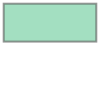

In [12]:
mgrs_geo = box(*df_mgrs_overlapping.total_bounds)
mgrs_geo

In [13]:
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])

In [14]:
stac = 'https://cmr.earthdata.nasa.gov/cloudstac/'    # CMR-STAC API Endpoint
api = Client.open(f'{stac}/LPCLOUD/')
collections = ['OPERA_L3_DIST-ALERT-HLS_V1']

search_params = {"collections": collections,
                 "intersects": mgrs_geo.__geo_interface__,
                 "datetime": [EVENT_DT - datetime.timedelta(days=14), POST_DT_STOP],
                 "max_items": 1_000}
search_dswx = api.search(**search_params)

In [15]:
l = list(search_dswx.items())

In [16]:
def get_mgrs_tile_from_id(opera_id: str) -> str:
    return opera_id.split('_')[3][1:]
l_temp = list(filter(lambda item: get_mgrs_tile_from_id(item.id) in event_dict['mgrs_tiles'], l))
tokens, opera_ids = [item.id.split('_') for item in l_temp], [item.id for item in l_temp]
l_temp = sorted(l_temp, key=lambda item: item.id)
id_dict = {}
for t, opera_id in zip(tokens, opera_ids):
    key = '_'.join(t[:5] + t[-3:])
    # should be ordered by recency so overwriting means later processing date
    id_dict[key]= opera_id
ids = list(id_dict.values())
l_f = [item for item in l_temp if item.id in ids]
len(l_temp), len(l), len(l_f)

(109, 560, 103)

In [17]:
def format_item(item):
    assets_status = [(key, value.href) for (key, value) in sorted(item.assets.items()) if ('STATUS' in value.href and '.tif' in value.href)]
    assets_status_m = [('dist-veg-status', value) if 'VEG' in key else ('dist-gen-status', value) for (key, value) in assets_status]

    assets_date = [(key, value.href) for (key, value) in sorted(item.assets.items()) if ('DATE' in value.href and '.tif' in value.href and 'LAST' not in value.href)]
    assets_date_m = [('dist-veg-date', value) if 'VEG' in key else ('dist-gen-date', value) for (key, value) in assets_date]
    
    out = {**{'id': item.id}, 
           **item.properties, 
           **{'geometry': shape(item.geometry)},
           **{key: value for (key, value) in assets_status_m + assets_date_m}
          }
    return out
    

In [18]:
data = list(map(format_item, l_f))
df_resp = pd.DataFrame(data)
df_resp = gpd.GeoDataFrame(df_resp, geometry=df_resp.geometry, crs=CRS.from_epsg(4326))
df_resp['datetime'] = pd.to_datetime(df_resp['datetime'])
df_resp['acq_date']= df_resp['datetime'].dt.date
df_resp['sensor'] = df_resp['id'].map(lambda oid: oid.split('_')[-3]) 
df_resp.head()

,id,eo:cloud_cover,datetime,start_datetime,end_datetime,geometry,dist-gen-status,dist-veg-status,dist-gen-date,dist-veg-date,acq_date,sensor
0,OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185051...,0,2024-07-10 18:50:51.367000+00:00,2024-07-10T18:50:51.367Z,2024-07-10T18:50:51.367Z,"POLYGON ((-121.87419 39.65615, -121.71107 40.1...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-07-10,L8
1,OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185919...,0,2024-07-10 19:13:23.999000+00:00,2024-07-10T19:13:23.999Z,2024-07-10T19:13:23.999Z,"POLYGON ((-121.96895 39.65703, -121.70626 40.4...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-07-10,S2B
2,OPERA_L3_DIST-ALERT-HLS_T10TEK_20240711T184440...,0,2024-07-11 18:44:40.886000+00:00,2024-07-11T18:44:40.886Z,2024-07-11T18:45:04.768Z,"POLYGON ((-121.72036 39.65456, -121.70166 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-07-11,L9
3,OPERA_L3_DIST-ALERT-HLS_T10TEK_20240712T184931...,0,2024-07-12 19:03:28.556000+00:00,2024-07-12T19:03:28.556Z,2024-07-12T19:03:28.556Z,"POLYGON ((-121.72036 39.65456, -121.70166 40.6...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-07-12,S2A
4,OPERA_L3_DIST-ALERT-HLS_T10TEK_20240715T185921...,3,2024-07-15 19:13:23.554000+00:00,2024-07-15T19:13:23.554Z,2024-07-15T19:13:23.554Z,"POLYGON ((-121.96230 39.65697, -121.70663 40.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2024-07-15,S2A


<Axes: >

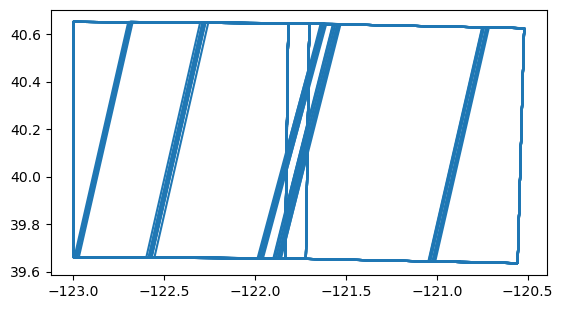

In [19]:
fig, ax = plt.subplots()
df_resp.exterior.plot(ax = ax)

In [20]:
df_resp.acq_date.unique()

array([datetime.date(2024, 7, 10), datetime.date(2024, 7, 11),
       datetime.date(2024, 7, 12), datetime.date(2024, 7, 15),
       datetime.date(2024, 7, 17), datetime.date(2024, 7, 18),
       datetime.date(2024, 7, 19), datetime.date(2024, 7, 20),
       datetime.date(2024, 7, 22), datetime.date(2024, 7, 25),
       datetime.date(2024, 7, 26), datetime.date(2024, 7, 27),
       datetime.date(2024, 7, 30), datetime.date(2024, 8, 1),
       datetime.date(2024, 8, 3), datetime.date(2024, 8, 4),
       datetime.date(2024, 8, 6), datetime.date(2024, 8, 9),
       datetime.date(2024, 8, 11), datetime.date(2024, 8, 12),
       datetime.date(2024, 8, 14), datetime.date(2024, 8, 16),
       datetime.date(2024, 8, 19), datetime.date(2024, 8, 20),
       datetime.date(2024, 8, 21), datetime.date(2024, 8, 24),
       datetime.date(2024, 8, 26), datetime.date(2024, 8, 27),
       datetime.date(2024, 8, 28), datetime.date(2024, 8, 29),
       datetime.date(2024, 8, 31), datetime.date(2024, 9, 3)

In [21]:
dist_hls_dir = Path('out') / event_dict['event_name'] / 'dist_hls'
dist_hls_dir.mkdir(exist_ok=True, parents=True)

In [22]:
zipped_inputs = []

for (sensor, date), df_rtc_date in df_resp.groupby(['sensor', 'acq_date']):
    dist_veg = df_rtc_date['dist-veg-status'].tolist()
    dist_gen = df_rtc_date['dist-gen-status'].tolist()

    dist_veg_date = df_rtc_date['dist-veg-date'].tolist()
    dist_gen_date = df_rtc_date['dist-gen-date'].tolist()
    
    date_dir = dist_hls_dir / f'{str(date)}__{sensor}'
    date_dir.mkdir(exist_ok=True, parents=True)

    zipped_inputs.extend([(url, date_dir) for url in dist_veg + dist_gen + dist_veg_date + dist_gen_date])

In [23]:
@backoff.on_exception(
    backoff.expo,
    [ConnectionError, HTTPError],
    max_tries=10,
    max_time=60,
    jitter=backoff.full_jitter,
)
def localize_one_file(
    url: str,
    dst_dir: str | Path
) -> Path:
    local_fn = url.split("/")[-1]
    out_path = dst_dir / local_fn
    if not dst_dir.exists():
        dst_dir.mkdir(parents=True)
    if out_path.exists():
        return out_path
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=16384): 
                f.write(chunk)
    return out_path

In [24]:
zipped_inputs[:3]

[('https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185051Z_20240712T060312Z_L8_30_v1/OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185051Z_20240712T060312Z_L8_30_v1_VEG-DIST-STATUS.tif',
  PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8')),
 ('https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T10TFK_20240710T185051Z_20240712T054041Z_L8_30_v1/OPERA_L3_DIST-ALERT-HLS_T10TFK_20240710T185051Z_20240712T054041Z_L8_30_v1_VEG-DIST-STATUS.tif',
  PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8')),
 ('https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/OPERA_L3_DIST-ALERT-HLS_V1/OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185051Z_20240712T060312Z_L8_30_v1/OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185051Z_20240712T060312Z_L8_30_v1_GEN-DIST-STATUS.tif',
  PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8'))]

In [25]:
localize_one_file(*zipped_inputs[0])

PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8/OPERA_L3_DIST-ALERT-HLS_T10TEK_20240710T185051Z_20240712T060312Z_L8_30_v1_VEG-DIST-STATUS.tif')

In [26]:
import concurrent.futures

def localize_one_file_p(data: tuple) -> Path:
    return localize_one_file(*data)

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths = list(tqdm(executor.map(localize_one_file_p, zipped_inputs[:]), total=len(zipped_inputs)))

  0%|          | 0/412 [00:00<?, ?it/s]

100%|██████████| 412/412 [01:52<00:00,  3.66it/s]


# Merge

In [27]:
all_acq_dirs = sorted([acq_dir for acq_dir in dist_hls_dir.glob('*')])
all_acq_dirs = list(filter(lambda p: p.is_dir(), all_acq_dirs))
all_acq_dirs[:3]

[PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8'),
 PosixPath('out/park_fire_2024/dist_hls/2024-07-10__S2B'),
 PosixPath('out/park_fire_2024/dist_hls/2024-07-11__L9')]

In [28]:
import concurrent.futures
import warnings
from typing import Union

import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.merge import merge
from rasterio.windows import Window
from shapely.geometry import box
from tqdm import tqdm

def merge_arrays_with_geometadata(
    arrays: list[np.ndarray],
    profiles: list[dict],
    resampling='bilinear',
    nodata = None,
    dtype: str = None,
    method='first',
) -> tuple[np.ndarray, dict]:
    n_dim = arrays[0].shape
    if len(n_dim) not in [2, 3]:
        raise ValueError('Currently arrays must be in BIP format' 'i.e. channels x height x width or flat array')
    if len(set([len(arr.shape) for arr in arrays])) != 1:
        raise ValueError('All arrays must have same number of dimensions i.e. 2 or 3')

    if len(n_dim) == 2:
        arrays_input = [arr[np.newaxis, ...] for arr in arrays]
    else:
        arrays_input = arrays

    if (len(arrays)) != (len(profiles)):
        raise ValueError('Length of arrays and profiles needs to be the same')

    memfiles = [MemoryFile() for p in profiles]
    datasets = [mfile.open(**p) for (mfile, p) in zip(memfiles, profiles)]
    [ds.write(arr) for (ds, arr) in zip(datasets, arrays_input)]

    if dtype is None:
        dst_dtype = profiles[0]['dtype']
    if nodata is None:
        dst_nodata = profiles[0]['nodata']

    merged_arr, merged_trans = merge(
        datasets, resampling=Resampling[resampling], method=method, nodata=dst_nodata, dtype=dst_dtype
    )

    prof_merged = profiles[0].copy()
    prof_merged['transform'] = merged_trans
    prof_merged['count'] = merged_arr.shape[0]
    prof_merged['height'] = merged_arr.shape[1]
    prof_merged['width'] = merged_arr.shape[2]
    prof_merged['nodata'] = dst_nodata
    prof_merged['dtype'] = dst_dtype
    
    [ds.close() for ds in datasets]
    [mfile.close() for mfile in memfiles]

    return merged_arr, prof_merged

In [29]:
#from dem_stitcher.merge import merge_arrays_with_geometadata

def get_crs(path: str) -> Path:
    with rasterio.open(path) as ds:
        crs = ds.crs
    return crs

def get_profile(path: Path) -> dict:
    with rasterio.open(path) as ds:
        p = ds.profile
    return p


def read_one(path: Path) -> tuple:
    with rasterio.open(path) as ds:
        p = ds.profile
        X = ds.read()
    return X, p

def merge_one_dir(acq_dir: Path, layer='gen-status') -> list:
    reg_dict = {'gen-status': 'GEN-DIST-STATUS.tif',
                'gen-date': 'GEN-DIST-DATE.tif',
                'veg-status': 'VEG-DIST-STATUS.tif',
                'veg-date': 'VEG-DIST-DATE.tif'}

    if layer not in reg_dict.keys():
        raise ValueError('layer not correctly specified')
    all_img_paths = sorted(list(acq_dir.glob(f'OPERA*{reg_dict[layer]}')))
    crs_l = list(map(get_crs, all_img_paths))
    
    
    stem = acq_dir.stem
    dst_path = acq_dir / f'__{stem}_{layer}_merged.tif'
    if len(list(set(crs_l))) == 1:
        merge(all_img_paths, method='first', dst_path=dst_path)
    else:
        profiles = list(map(get_profile, all_img_paths))
        ref_crs = crs_l[0]
        ref_profile = profiles[0]

        if 'status' in layer:
            with rasterio.open(all_img_paths[0]) as ds:
                cmap = ds.colormap(1)
        zipped_data = [read_one(path) for path in all_img_paths]
        zipped_data = [(X, p) if p['crs'] == ref_crs 
                       else reproject_arr_to_new_crs(X, 
                                                     p, 
                                                     ref_crs, 
                                                     resampling='nearest') 
                       for (X, p) in zipped_data ]
        arrays, profiles_dst = zip(*zipped_data)
        arrays = [arr[0, ...] for arr in arrays]
        X_m, p_m = merge_arrays_with_geometadata(arrays, 
                                                 profiles_dst, 
                                                 resampling='nearest',
                                                 method='first')
        with rasterio.open(dst_path, 'w', **p_m) as ds:
            ds.write(X_m)
            if 'status' in layer:
                ds.write_colormap(1, cmap)
    return dst_path

In [30]:
# merge_one_dir(all_acq_dirs[0], layer='veg-status')

In [31]:
# dst_paths_veg_status = [merge_one_dir(acq_dir, layer='veg-status') for acq_dir in tqdm(all_acq_dirs)]
# dst_paths_veg_date = [merge_one_dir(acq_dir, layer='veg-date') for acq_dir in tqdm(all_acq_dirs)]
# dst_paths_gen_status = [merge_one_dir(acq_dir, layer='gen-status') for acq_dir in tqdm(all_acq_dirs)]
# dst_paths_gen_date = [merge_one_dir(acq_dir, layer='gen-date') for acq_dir in tqdm(all_acq_dirs)]
# dst_paths_veg_status, dst_paths_gen_status

In [32]:
merge_inputs = [(acq_dir, layer) for acq_dir in all_acq_dirs for layer in ['veg-status', 'gen-status', 'veg-date', 'gen-date']]

with WorkerPool(n_jobs=5, use_dill=True) as pool:
    dst_paths = pool.map(
        merge_one_dir,
        merge_inputs,
        progress_bar=True,\
        progress_bar_style="std",
    )
dst_paths[:3]

100%|██████████| 224/224 [00:15<00:00,  9.49it/s]


[PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8/__2024-07-10__L8_veg-status_merged.tif'),
 PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8/__2024-07-10__L8_gen-status_merged.tif'),
 PosixPath('out/park_fire_2024/dist_hls/2024-07-10__L8/__2024-07-10__L8_veg-date_merged.tif')]

# Reproject TS into single Frame

In [33]:
ts_dir = dist_hls_dir.parent / 'dist_hls_ts_merged'
ts_dir.mkdir(exist_ok=True, parents=True)
ts_dir

PosixPath('out/park_fire_2024/dist_hls_ts_merged')

In [34]:
import shutil
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
from dem_stitcher.rio_window import get_indices_from_extent
from rasterio.warp import transform_bounds
from rasterio.transform import xy
from affine import Affine

def get_idx_with_largest_size(paths: list[Path]) -> int:
    def get_size(path: Path) -> int:
        with rasterio.open(path) as ds:
            m, n = ds.shape

        return m * n

    sizes = list(map(get_size, paths))
    idx = np.argmax(sizes)
    return idx

def make_cube(paths: list[Path]):
    track_number = paths[0].stem.split('_')[2]
    date = paths[0].stem.split('_')[3]
    
    ref_idx = get_idx_with_largest_size(paths)

    def get_profile(path: Path) -> dict:
        with rasterio.open(path) as ds:
            p = ds.profile
        return p

    profiles = list(map(get_profile, paths))
    ref_profile = profiles[ref_idx]

    def align_for_cube(path, prof):
        out_path = ts_dir / path.name
        cond0 = (prof['transform'] == ref_profile['transform'])
        cond1 = (prof['width'] == ref_profile['width'])
        cond2 = (prof['height'] == ref_profile['height'])
        cond3 = (prof['crs'] == ref_profile['crs'])
            
        p_r = prof.copy()
        if not (cond0 and cond1 and cond2 and cond3):
            with rasterio.open(path) as ds:
                X = ds.read(1)
                if 'status' in path.stem.lower():
                    cmap = ds.colormap(1)
            X_r, p_r = reproject_arr_to_match_profile(X, prof, ref_profile)
            X_r = X_r[0, ...]
            
            with rasterio.open(out_path, 'w', **p_r) as ds:
                ds.write(X_r, 1)
                if 'status' in path.stem.lower():
                    ds.write_colormap(1, cmap)
        else:
            shutil.copy(path, out_path)
        return out_path
    cube_inputs = list(zip(paths, profiles))
    #cube_paths = [align_for_cube(*inp) for inp in cube_inputs]
    with WorkerPool(n_jobs=5, use_dill=True) as pool:
        cube_paths = pool.map(
            align_for_cube,
            cube_inputs,
            progress_bar=True,\
            progress_bar_style="std",
            )
    return cube_paths

In [35]:
%%time

cube_paths = sorted(make_cube(dst_paths))
cube_paths[:4]

100%|██████████| 224/224 [00:05<00:00, 31.70it/s]

CPU times: user 693 ms, sys: 150 ms, total: 843 ms
Wall time: 6.2 s


[PosixPath('out/park_fire_2024/dist_hls_ts_merged/__2024-07-10__L8_gen-date_merged.tif'),
 PosixPath('out/park_fire_2024/dist_hls_ts_merged/__2024-07-10__L8_gen-status_merged.tif'),
 PosixPath('out/park_fire_2024/dist_hls_ts_merged/__2024-07-10__L8_veg-date_merged.tif'),
 PosixPath('out/park_fire_2024/dist_hls_ts_merged/__2024-07-10__L8_veg-status_merged.tif')]

# Divide paths

In [36]:
merged_veg_status = [p for p in cube_paths if 'veg-status' in p.stem]
merged_gen_status = [p for p in cube_paths if 'gen-status' in p.stem]

merged_veg_date = [p for p in cube_paths if 'veg-date' in p.stem]
merged_gen_date = [p for p in cube_paths if 'gen-date' in p.stem]

# Make Change Map

In [37]:
change_dir = Path('out') / event_dict['event_name'] / 'change_map_dist_hls'
change_dir.mkdir(exist_ok=True, parents=True)

In [38]:
from dateparser import parse
acq_dt_hls = [parse(p.stem.split('__')[1]) for p in merged_veg_status]
acq_dt_hls[:3]

[datetime.datetime(2024, 7, 10, 0, 0),
 datetime.datetime(2024, 7, 10, 0, 0),
 datetime.datetime(2024, 7, 11, 0, 0)]

## Change Maps from Provisional Alert

In [39]:
N_ACQS = 3

In [40]:
PROVISIONAL_CHANGE_MAP_IDXS = [k for (k, dt) in enumerate(acq_dt_hls) if dt > EVENT_DT][:3]
PROVISIONAL_CHANGE_MAP_IDXS, [acq_dt_hls[k] for k in PROVISIONAL_CHANGE_MAP_IDXS]

([12, 13, 14],
 [datetime.datetime(2024, 7, 25, 0, 0),
  datetime.datetime(2024, 7, 26, 0, 0),
  datetime.datetime(2024, 7, 27, 0, 0)])

In [41]:
for data_list, change_token in zip([merged_veg_status, merged_gen_status], ['veg', 'gen']):
    profiles = []
    change_arrays = []
    for idx in PROVISIONAL_CHANGE_MAP_IDXS:
        with rasterio.open(data_list[idx]) as ds:
            X_status_prov = ds.read(1)
            p = ds.profile
        
        X_change_prov = np.zeros(X_status_prov.shape)
    
        confirmed_change_labels = [3, 6, 7, 8]
        X_change_prov[np.isin(X_status_prov, confirmed_change_labels)] = 255
    
        prov_change_labels = [1, 2, 3, 5]
        X_change_prov[np.isin(X_status_prov, prov_change_labels)] = 1
    
        #no_change_labels = [0]
        #X_change_prov[np.isin(X_status_prov, no_change_labels)] = 0
    
        X_change_prov[X_status_prov == 255] = 255
        
        profiles.append(p)
        change_arrays.append(X_change_prov)

    X_change_prov_m, p_m = merge_arrays_with_geometadata(change_arrays, profiles, method='max')

    out_path = change_dir / f'dist_hls_provisional_change_map_{change_token}_first{str(acq_dt_hls[PROVISIONAL_CHANGE_MAP_IDXS[0]].date())}.tif'
    print(out_path)
    with rasterio.open(out_path, 'w', **p_m) as ds:
        ds.write(X_change_prov_m.astype(np.uint8))
    

out/park_fire_2024/change_map_dist_hls/dist_hls_provisional_change_map_veg_first2024-07-25.tif
out/park_fire_2024/change_map_dist_hls/dist_hls_provisional_change_map_gen_first2024-07-25.tif


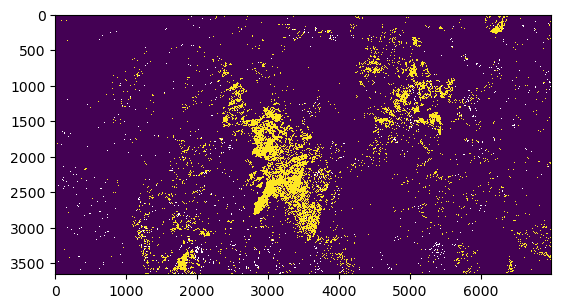

In [42]:
X_change_prov_p = X_change_prov.copy()
X_change_prov_p[X_change_prov_p == 255] = np.nan
plt.imshow(X_change_prov_p, vmin=0, vmax=1, interpolation='none')

## Confirmed Change Map

In [43]:
min_days = event_dict['dist_hls_confirmed_change_min_days']
min_days

15

In [44]:
EVENT_DT

datetime.datetime(2024, 7, 24, 0, 0)

In [45]:
acq_dt_hls

[datetime.datetime(2024, 7, 10, 0, 0),
 datetime.datetime(2024, 7, 10, 0, 0),
 datetime.datetime(2024, 7, 11, 0, 0),
 datetime.datetime(2024, 7, 12, 0, 0),
 datetime.datetime(2024, 7, 12, 0, 0),
 datetime.datetime(2024, 7, 15, 0, 0),
 datetime.datetime(2024, 7, 17, 0, 0),
 datetime.datetime(2024, 7, 18, 0, 0),
 datetime.datetime(2024, 7, 19, 0, 0),
 datetime.datetime(2024, 7, 20, 0, 0),
 datetime.datetime(2024, 7, 20, 0, 0),
 datetime.datetime(2024, 7, 22, 0, 0),
 datetime.datetime(2024, 7, 25, 0, 0),
 datetime.datetime(2024, 7, 26, 0, 0),
 datetime.datetime(2024, 7, 27, 0, 0),
 datetime.datetime(2024, 7, 27, 0, 0),
 datetime.datetime(2024, 7, 28, 0, 0),
 datetime.datetime(2024, 7, 30, 0, 0),
 datetime.datetime(2024, 8, 1, 0, 0),
 datetime.datetime(2024, 8, 3, 0, 0),
 datetime.datetime(2024, 8, 4, 0, 0),
 datetime.datetime(2024, 8, 4, 0, 0),
 datetime.datetime(2024, 8, 5, 0, 0),
 datetime.datetime(2024, 8, 6, 0, 0),
 datetime.datetime(2024, 8, 9, 0, 0),
 datetime.datetime(2024, 8, 11, 

In [46]:
CHANGE_MAP_CONFIRMED_IDXS = [k for (k, dt) in enumerate(acq_dt_hls) if dt > (EVENT_DT + datetime.timedelta(min_days))][:N_ACQS]
CHANGE_MAP_CONFIRMED_IDXS, [acq_dt_hls[k] for k in CHANGE_MAP_CONFIRMED_IDXS]

([24, 25, 26],
 [datetime.datetime(2024, 8, 9, 0, 0),
  datetime.datetime(2024, 8, 11, 0, 0),
  datetime.datetime(2024, 8, 11, 0, 0)])

In [47]:
for data_list_status, data_list_date, change_token in zip([merged_veg_status, merged_gen_status], 
                                          [merged_veg_date, merged_gen_date],
                                          ['veg', 'gen']):
    profiles = []
    change_arrays = []
    for idx in CHANGE_MAP_CONFIRMED_IDXS:
    
        with rasterio.open(data_list_status[idx]) as ds:
            X_status_con = ds.read(1)
            p = ds.profile
    
        with rasterio.open(data_list_date[idx]) as ds:
            X_date = ds.read(1)
    
        confirmed_event_day_val = (EVENT_DT - datetime.datetime(2020, 12, 31)).days
        X_change_con = np.zeros(X_status_con.shape)
        
        confirmed_change_labels = [3, 6, 7, 8]
        # I am adding a 1 day buffer to the confirmed day boolean index
        X_change_con[np.isin(X_status_con, confirmed_change_labels) & (X_date >= confirmed_event_day_val - 1)] = 1
    
        #prov_change_labels = [1, 2, 3, 5]
        #X_change_con[np.isin(X_status_con, prov_change_labels)] = 255
        
        X_change_con[X_status_con == 255] = 255

        profiles.append(p)
        change_arrays.append(X_change_con)

    X_change_con_m, p_m = merge_arrays_with_geometadata(change_arrays, profiles, method='max')


    out_path = change_dir / f'dist_hls_confirmed_change_map_{change_token}_first{str(acq_dt_hls[CHANGE_MAP_CONFIRMED_IDXS[0]].date())}.tif'
    print(out_path)
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(X_change_con_m.astype(np.uint8))
    

out/park_fire_2024/change_map_dist_hls/dist_hls_confirmed_change_map_veg_first2024-08-09.tif
out/park_fire_2024/change_map_dist_hls/dist_hls_confirmed_change_map_gen_first2024-08-09.tif


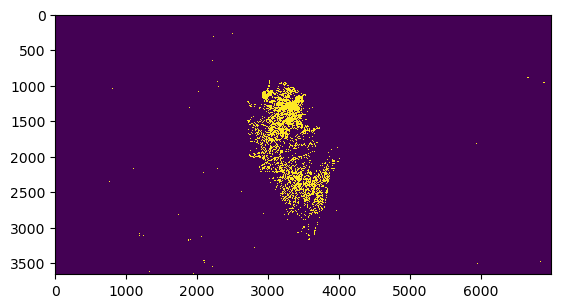

In [48]:
plt.imshow(X_change_con_m[0, ...], vmin=0, vmax=1, interpolation='none')

# Remove DIST-HLS files

In [49]:
ts_dir, dist_hls_dir

(PosixPath('out/park_fire_2024/dist_hls_ts_merged'),
 PosixPath('out/park_fire_2024/dist_hls'))

In [50]:
shutil.rmtree(ts_dir)
shutil.rmtree(dist_hls_dir)